In [3]:
import pandas as pd
import numpy as np
import re
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline

/Users/sunkuo/anaconda/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


ImportError: No module named 'xgboost'

In [4]:
df = pd.read_csv('NYT_df.csv')

In [5]:
df['Article'] = df['Article'].apply(lambda x:str(x))

In [6]:
df_ne = df.drop(df[df.Article =='nan'].index)

In [7]:
df_ne['polarity'] = df_ne['Article'].apply(lambda x: TextBlob(x).sentiment[0])
df_ne['subjectivity'] = df_ne['Article'].apply(lambda x: TextBlob(x).sentiment[1])

In [8]:
df_ne['Article'] = df_ne['Article'].apply(lambda x: re.sub('((\\n)|(/\\n)+)', ' ', x)).apply(lambda x: re.sub('[^A-Za-z]+', ' ', x))

In [9]:
df_ne.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_ne.Article) 

In [11]:
type(X)
X.shape

(594, 19131)

In [12]:
pca = PCA(n_components=(X.shape[1]))
pca_x = pca.fit_transform(X.toarray())
pca_x.shape

In [13]:
pca_x.shape

(594, 594)

In [98]:
km_cluster = KMeans(n_clusters=3, init='k-means++', n_init=10)
kmeans_array = km_cluster.fit_transform(X)
clusters_array = km_cluster.predict(X)
df_ne['cluster'] = clusters_array

/Users/sunkuo/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [99]:
km_cluster1 = KMeans(n_clusters=2, init='k-means++', n_init=25)
kmeans_pca_array = km_cluster1.fit_transform(pca_x)
pca_clusters_array = km_cluster1.predict(pca_x)
df_ne['pca_cluster'] = pca_clusters_array


In [14]:
n_inertia = []
for i in range(1,16):
    km = KMeans(n_clusters = i, init = 'k-means++', n_init=25)
    kmeans_pca_array = km.fit_transform(pca_x)
    pca_clusters_array = km.predict(pca_x)
    inertia = km.inertia_
    n_inertia.append(inertia)

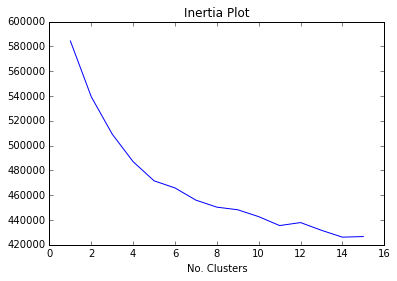

In [18]:
plt.plot(range(1,16),n_inertia)
plt.title('Inertia Plot')
plt.xlabel('No. Clusters')

In [102]:
km_cluster1 = KMeans(n_clusters=4, init='k-means++', n_init=25)
kmeans_pca_array = km_cluster1.fit_transform(pca_x)
pca_clusters_array = km_cluster1.predict(pca_x)
df_ne['pca_cluster'] = pca_clusters_array

In [103]:
df_ne['pca_cluster'].value_counts()

3    310
1    157
2    126
0      1
Name: pca_cluster, dtype: int64

In [75]:
#df_ne.head(2)

In [344]:
#plt.hist(df_ne['polarity'])

In [343]:
#plt.hist(df_ne['subjectivity'])

In [342]:
#sorted(np.array(df_ne['Pub_date']))

In [89]:
def cluster_words(cluster_num, array):
    stemmer = nltk.stem.porter.PorterStemmer()
    tmp = ''
    stop = stopwords.words('english')
    stop.extend(('said', 'also'))
    for i in df_ne[array == cluster_num]['Article']:
        tmp = tmp + ' '  + i.lower()
    words = nltk.word_tokenize(tmp)
    stopwordsfree = [stemmer.stem(word) for word in words if word not in stop]
    return pd.Series(stopwordsfree).value_counts()

In [58]:
#cluster_words(0, df_ne['cluster'])[:20]

In [142]:
#cluster_words(1)[:20]

In [145]:
#cluster_words(2)[:20]

In [146]:
#cluster_words(3)[:20]

In [147]:
#cluster_words(4)[:20]

** ========================================================================================================= **

In [339]:
#cluster_words(0, df_ne['pca_cluster'])[:50]

In [338]:
#cluster_words(1, df_ne['pca_cluster'])[:50]

In [104]:
def word_counter(cluster_num, array):
    stemmer = nltk.stem.porter.PorterStemmer()
    tmp = ''
    stop = stopwords.words('english')
    stop.extend(('said', 'also'))
    for i in df_ne[array == cluster_num]['Article']:
        tmp = tmp + ' '  + i.lower()
    words = nltk.word_tokenize(tmp)
    stopwordsfree = [stemmer.stem(word) for word in words if word not in stop]
    return sorted(collections.Counter(stopwordsfree), key = (lambda x: x[1]))

In [340]:
#sorted(word_counter(0, df_ne['pca_cluster']).items(), key=lambda x: x[1], reverse=True)[:50]

In [341]:
#sorted(word_counter(1, df_ne['pca_cluster']).items(), key=lambda x: x[1], reverse=True)[:50]

range(0, 263)
263


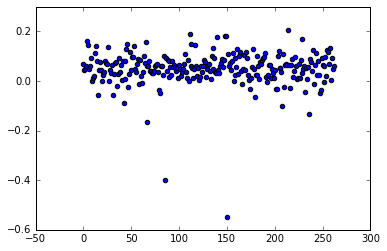

In [105]:
sentiment_df = pd.DataFrame(df_ne.groupby(['Pub_date'])['polarity'].mean())
plt.scatter(range(len(sentiment_df)), sentiment_df['polarity'])
print(range(len(sentiment_df)))
print(len(sentiment_df['polarity']))

In [106]:
cl1 = pd.DataFrame(cluster_words(0, df_ne['pca_cluster'])[:32])
cl1.to_csv('cluster1.csv')

In [107]:
cl2 = pd.DataFrame(cluster_words(1, df_ne['pca_cluster'])[:32])
cl2.to_csv('cluster2.csv')

In [108]:
cl3 = pd.DataFrame(cluster_words(2, df_ne['pca_cluster'])[:32])
cl3.to_csv('cluster3.csv')

In [109]:
cl4 = pd.DataFrame(cluster_words(3, df_ne['pca_cluster'])[:32])
cl4.to_csv('cluster4.csv')

** ========================================================================================================= **

In [114]:
import lda

In [111]:
X.shape

(594, 19131)

In [117]:
lda_mod = lda.LDA(n_topics=10, n_iter=500, random_state=1)
lda_mod.fit_transform(X)  # model.fit_transform(X) is also available

array([[  2.18329466e-01,   3.43619490e-01,   2.50812065e-01, ...,
          2.32018561e-04,   2.32018561e-04,   2.32018561e-04],
       [  2.76470588e-02,   2.96078431e-02,   2.70784314e-01, ...,
          1.00196078e-01,   1.96078431e-04,   5.31568627e-01],
       [  2.47524752e-04,   2.72277228e-03,   9.18316832e-02, ...,
          4.72772277e-02,   4.97772277e-01,   2.75000000e-01],
       ..., 
       [  5.18779343e-02,   2.34741784e-04,   1.73943662e-01, ...,
          4.92957746e-03,   2.34741784e-04,   1.22300469e-01],
       [  4.82745098e-01,   5.92156863e-02,   2.98431373e-01, ...,
          3.92156863e-04,   3.92156863e-04,   8.66666667e-02],
       [  6.18104668e-02,   2.96605375e-01,   2.65959453e-01, ...,
          4.01225837e-02,   4.71475719e-05,   9.00518623e-03]])

In [118]:
topic_word = lda_mod.topic_word_  # model.components_ also works

In [120]:
print( type(topic_word))
print( topic_word.shape)
print( topic_word[0][:20])
print( topic_word[0].sum())

<class 'numpy.ndarray'>
(10, 19131)
[  6.97140539e-07   6.97140539e-07   6.97140539e-07   1.40125248e-04
   6.97140539e-07   6.97140539e-07   6.97140539e-07   6.97140539e-07
   6.97140539e-07   6.97140539e-07   6.97140539e-07   6.97140539e-07
   6.97140539e-07   6.97140539e-07   6.97140539e-07   6.97140539e-07
   6.97140539e-07   6.97140539e-07   6.97140539e-07   6.97140539e-07]
1.0
